In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn import metrics

warnings.filterwarnings("ignore")

In [66]:
data = pd.read_csv('clean_dataset.csv')
data.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


In [67]:
d1 = {'Industrials':0, 'Materials':1, 'CommunicationServices':2, 'Transport':3,
       'InformationTechnology':4, 'Financials':5, 'Energy':6, 'Real Estate':7,
       'Utilities':8, 'ConsumerDiscretionary':9, 'Education':10,
       'ConsumerStaples':11, 'Healthcare':12, 'Research':13}

d2 = {'White':0, 'Black':1, 'Asian':2, 'Latino':3, 'Other':4}
d3 = {'ByBirth':0, 'ByOtherMeans':1, 'Temporary':2}

data['Industry'] = data['Industry'].map(d1)
data['Ethnicity'] = data['Ethnicity'].map(d2)
data['Citizen'] = data['Citizen'].map(d3)

In [68]:
train, test = train_test_split(data, test_size=0.2,random_state=1)

<Axes: >

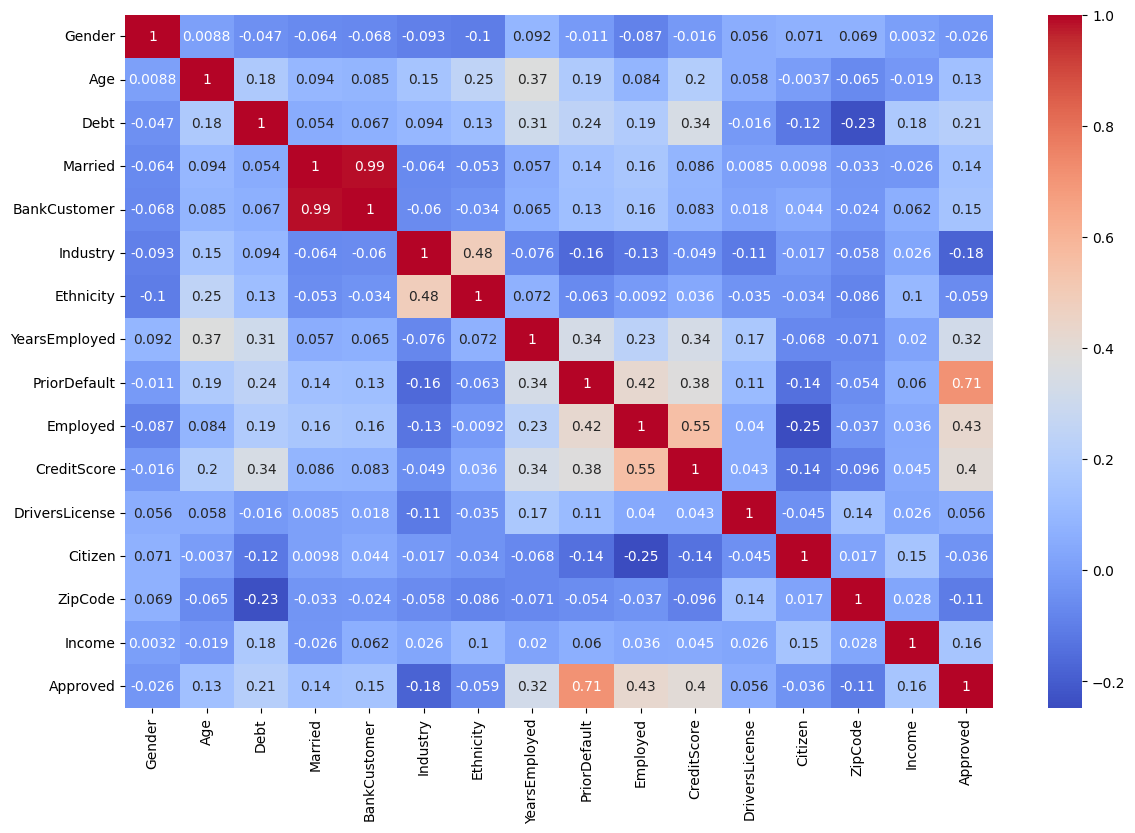

In [69]:
plt.figure(figsize=(14,9))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

### The features correlations shows that some features have very hight correlations, which make the Naive bayes rule not valid 
### to avoid one of the features (Married and BankCustomer) i chose married since it has lower correlation with the Approval outcome

In [70]:
# class 0 > not Approved, class 1 > Approved
# N0, N1 > number of samples of class 0 , 1
N0 = np.where(train['Approved']==0)[0].shape[0]
N1 = np.where(train['Approved']==1)[0].shape[0]

# class 0 points > X0 ,  class 1 points > X1 
X0 = train[train['Approved']==0].drop(['Approved','Married'],axis=1).to_numpy()
X1 = train[train['Approved']==1].drop(['Approved','Married'],axis=1).to_numpy()

# class 0: probability > P(C0) = Pi , P(C1) = 1 - Pi
Pi =  N0/(N0+N1)

# class 0, 1  means M0, M1
M0 = np.sum(X0,axis=0) / N0
M1 = np.sum(X1,axis=0) / N1

#class 0, 1 covariances
S0 = (X0-M0).T.dot((X0-M0)) / N0
S1 = (X1-M1).T.dot((X1-M1)) / N1

# classes covariance matrix
cov = (N0*S0+N1*S1)/(N0+N1) 


In [71]:
# to visualize the classes distribution and the decision boundary, select the features  (PriorDefault, Employed) (7, 8) after removing married
# select just two features (PriorDefault, Employed)
feature1Index = 7
feature2Index = 8
#YearsEmployed
X1 = np.arange(-2.5, 2.5, 0.05) 
# CreditScore
X2 = np.arange(-2.5, 2.5, 0.05) 
X1, X2 = np.meshgrid(X1, X2)

# Class 0 mean
SM0 = np.array([M0[feature1Index], M0[feature2Index]])
# Class 1 mean
SM1 = np.array([M1[feature1Index], M1[feature2Index]])
#classes covariance
SCov = np.array([[cov[feature1Index,feature1Index], cov[feature1Index,feature2Index]],
                  [cov[feature2Index,feature1Index], cov[feature2Index,feature2Index]]])

#decision boundary calculations P(C0|X)
invCov = np.linalg.inv(SCov)
W = invCov.dot(SM0-SM1)
W0 = - (1/2)*(SM0.T.dot(invCov.dot(SM0)))  +  (1/2)*(SM1.T.dot(invCov.dot(SM1))) + np.log(Pi/(1-Pi))
probabilityOfClass0GivenX = W[0]*X1+W[1]*X2+W0
probabilityOfClass0GivenX = 1/(1+np.exp(-probabilityOfClass0GivenX))


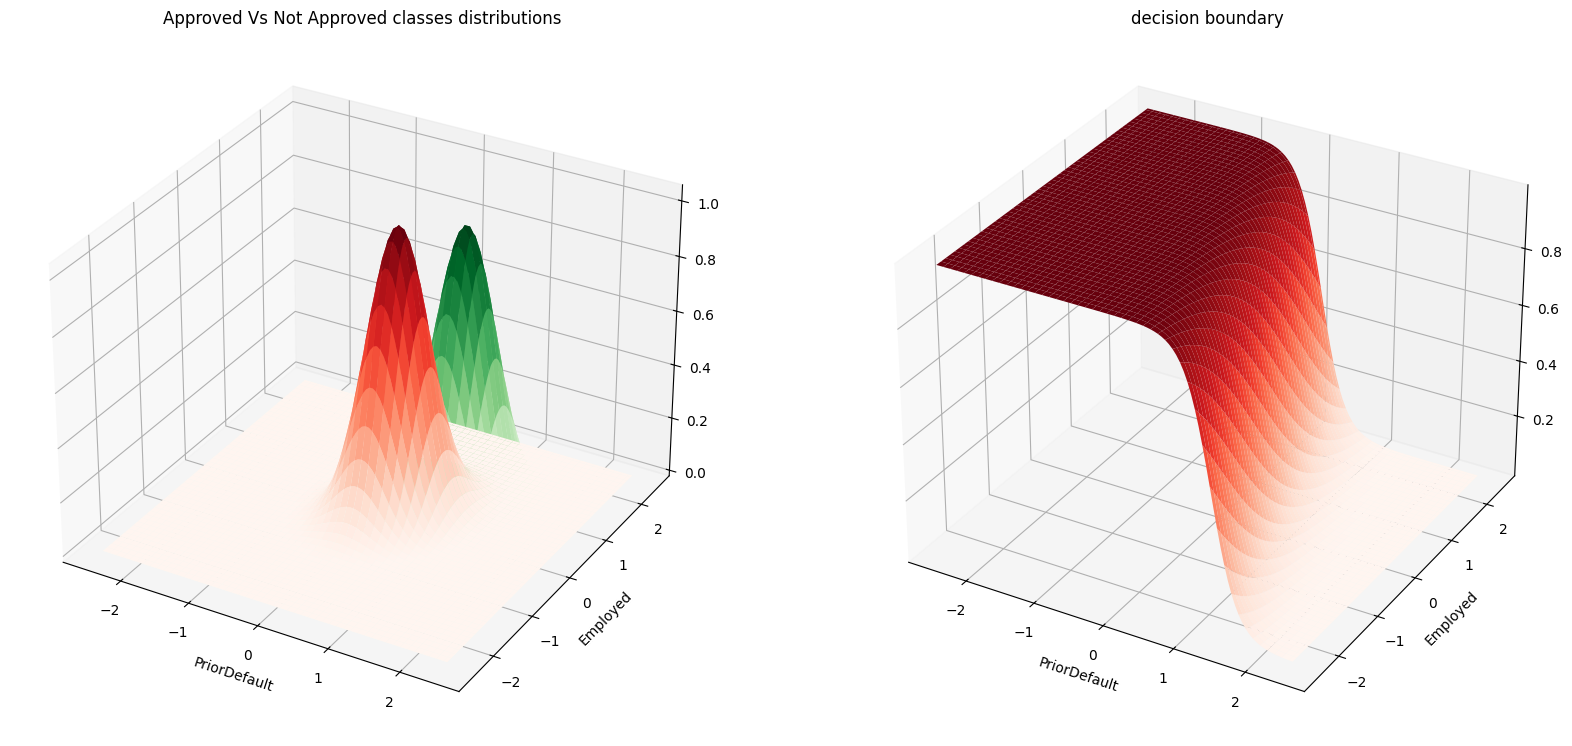

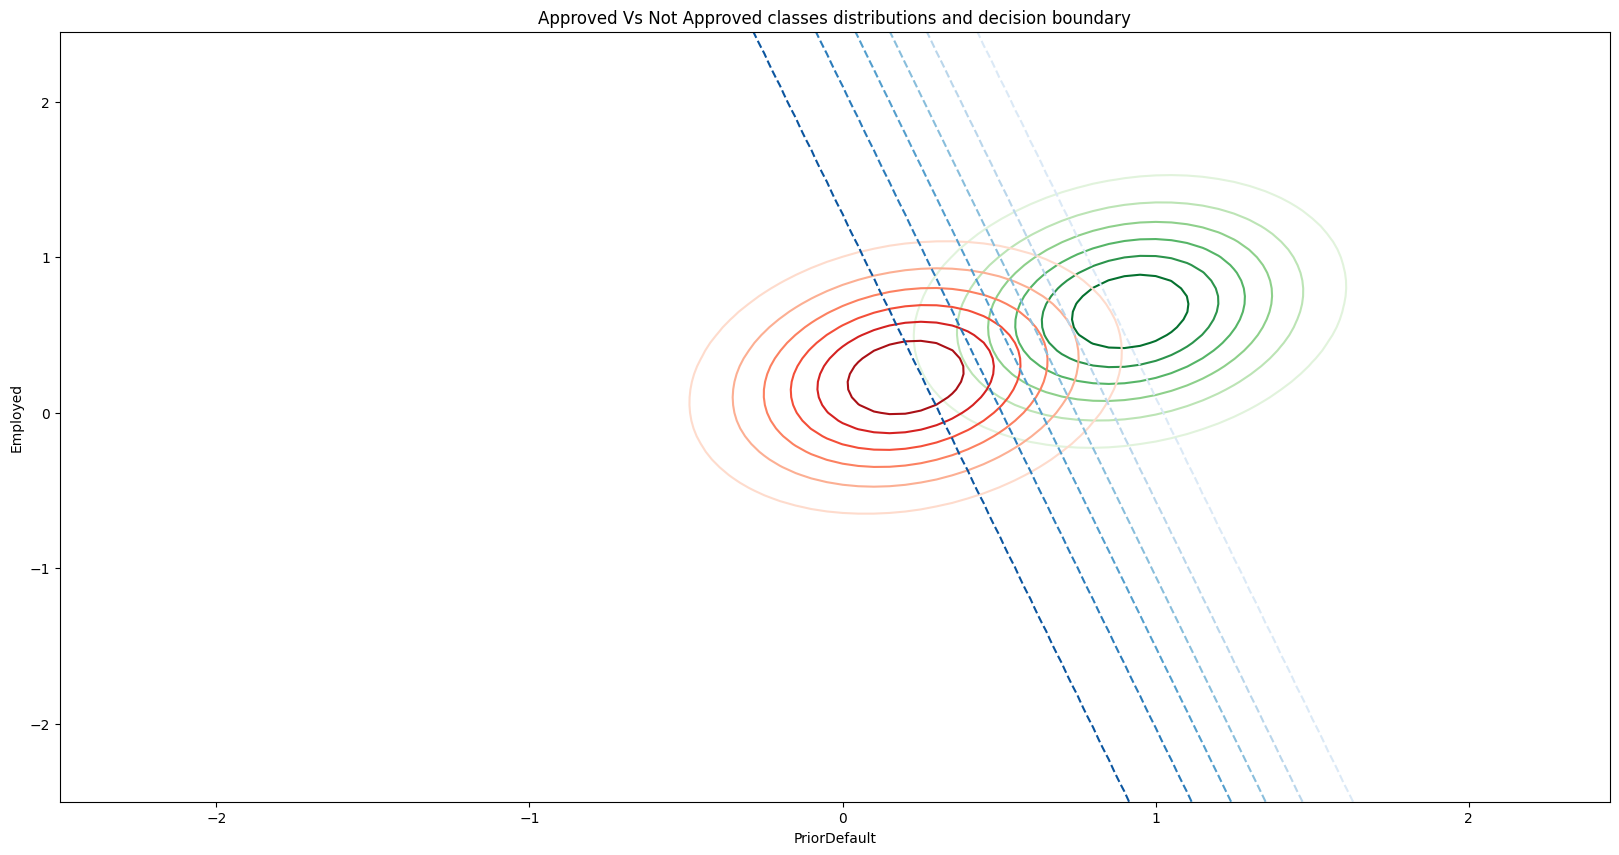

[0.2012987012987013, 0.22727272727272727]
[0.9180327868852459, 0.6516393442622951]


In [72]:
# create an empty array of the same shape as X to hold the (x, y) coordinates
pos = np.empty(X1.shape + (2,))

# fill the pos array with the x and y coordinates
pos[:, :, 0] = X1  
pos[:, :, 1] = X2  

# create a multivariate normal distribution using the defined parameters which is the probability of X given each class 
#P(X|C0)
probabilityOfXGivenClass0 = multivariate_normal(SM0, SCov).pdf(pos)
#P(X|C1)
probabilityOfXGivenClass1 = multivariate_normal(SM1, SCov).pdf(pos)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection = '3d')
b=ax.plot_surface(X1, X2, probabilityOfXGivenClass1,cmap='Greens')
a=ax.plot_surface(X1, X2, probabilityOfXGivenClass0,cmap='Reds')
plt.xlabel('PriorDefault')
plt.ylabel('Employed')
plt.title('Approved Vs Not Approved classes distributions')

ax = fig.add_subplot(122, projection = '3d')
a=ax.plot_surface(X1, X2, probabilityOfClass0GivenX,cmap='Reds')
plt.xlabel('PriorDefault')
plt.ylabel('Employed')
plt.title('decision boundary')


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
b=ax.contour(X1, X2, probabilityOfXGivenClass1,cmap='Greens')
a=ax.contour(X1, X2, probabilityOfXGivenClass0,cmap='Reds')
c=ax.contour(X1, X2, probabilityOfClass0GivenX,cmap='Blues',linestyles='dashed') 
plt.xlabel('PriorDefault')
plt.ylabel('Employed')
plt.title('Approved Vs Not Approved classes distributions and decision boundary')

plt.show()

print([M0[feature1Index], M0[feature2Index]])
print([M1[feature1Index], M1[feature2Index]])

In [73]:
# inference stage
#decision boundary calculations P(C0|X)
invCov = np.linalg.inv(cov)
W = invCov.dot(M0-M1)
W0 = - 1/2*(M0.T.dot(invCov.dot(M0)))  +  1/2*(M1.T.dot(invCov.dot(M1))) + np.log(Pi/(1-Pi))
# all training data XTrain , and testing Data XTest
XTrain = train.drop(['Approved','Married'],axis=1).to_numpy()
YTrain = train['Approved'].to_numpy()
XTest = test.drop(['Approved','Married'],axis=1).to_numpy()
YTest = test['Approved'].to_numpy()

Training Accuracy  0.8532608695652174
Training F-score  0.8586387434554974


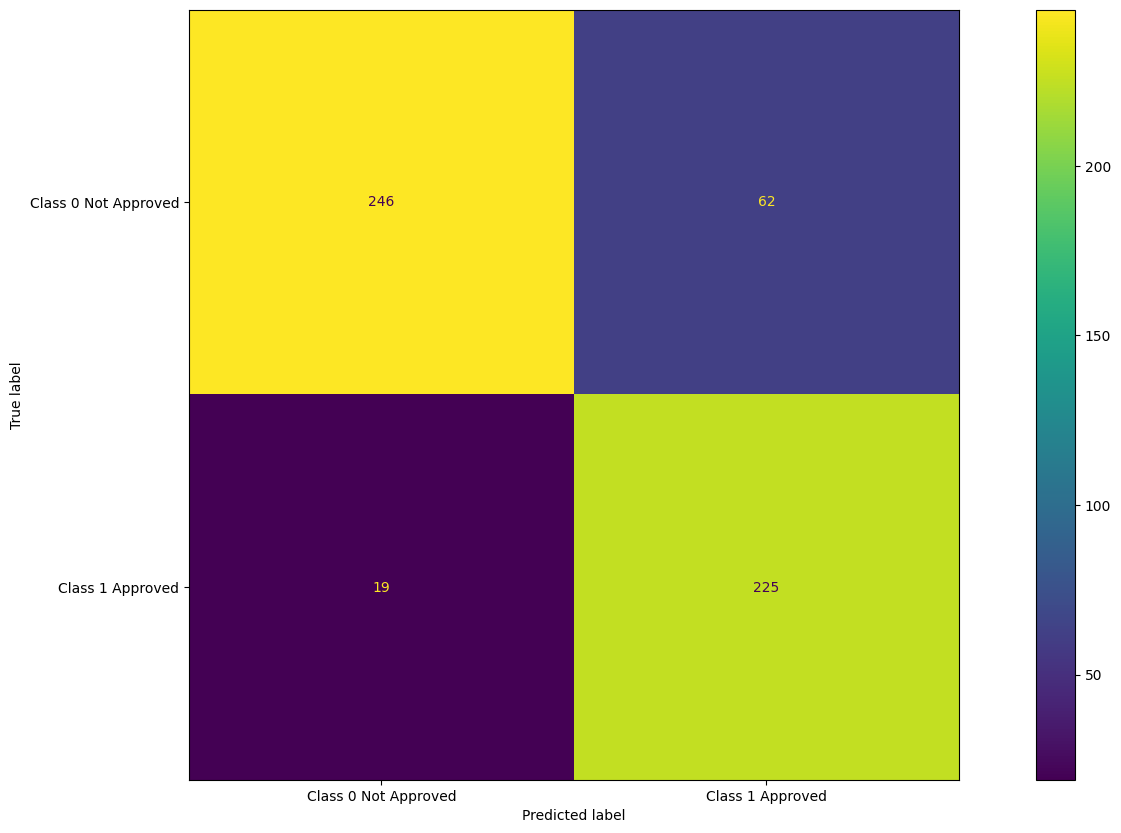

In [74]:
probabilityOfClass0GivenX_Training = XTrain.dot(W)+W0
probabilityOfClass0GivenX_Training = 1/(1+np.exp(-probabilityOfClass0GivenX_Training))
prediction = probabilityOfClass0GivenX_Training.copy()
prediction[probabilityOfClass0GivenX_Training>=0.5]=0
prediction[probabilityOfClass0GivenX_Training<0.5]=1


TruePositive = np.where(np.logical_and(YTrain == prediction , prediction==0))[0].shape[0]
TrueNegative = np.where(np.logical_and(YTrain == prediction , prediction==1))[0].shape[0]
FalsePositive = np.where(np.logical_and(YTrain != prediction , prediction==0))[0].shape[0]
FalseNegative = np.where(np.logical_and(YTrain != prediction , prediction==1))[0].shape[0]
totalPredictions = prediction.shape[0]
Accuracy = (TruePositive+TrueNegative)/totalPredictions # (True Positive + True Negative) / Total Predictions is 
Precision = (TruePositive)/(TruePositive+FalsePositive) # Precision True Positive / (True Positive + False Positive)
Recall = (TruePositive)/(TruePositive+FalseNegative) # Recall True Positive / (True Positive + False Negative)
F_score = 2*(Precision*Recall)/(Precision + Recall) # 2 * ((Precision * Recall) / (Precision + Recall))
print("Training Accuracy ",Accuracy)
print("Training F-score ",F_score)
fig, ax = plt.subplots(1,1,figsize=(20,10))
confusion_matrix = metrics.confusion_matrix(YTrain, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Class 0 Not Approved", "Class 1 Approved"])
cm_display.plot(ax=ax)

Testing Accuracy  0.8768115942028986
Testing F-score  0.8776978417266187


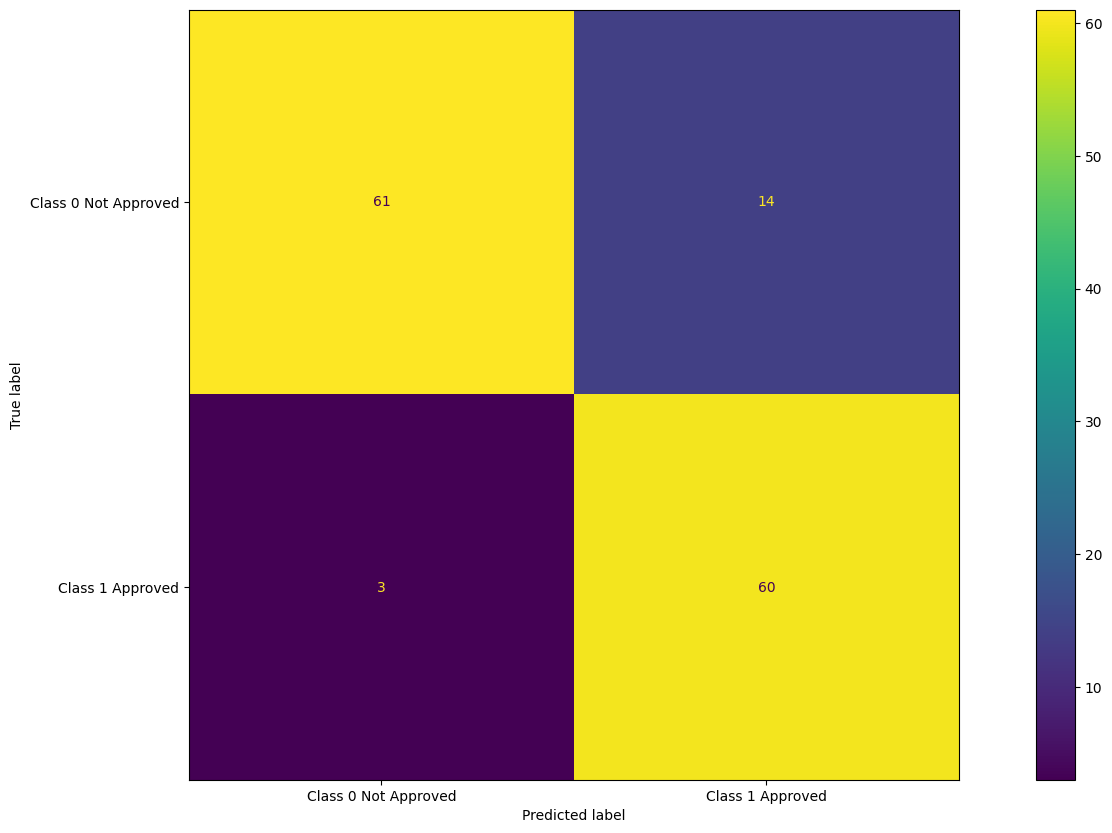

In [75]:
probabilityOfClass0GivenX_Testing = XTest.dot(W)+W0
probabilityOfClass0GivenX_Testing = 1/(1+np.exp(-probabilityOfClass0GivenX_Testing))
prediction = probabilityOfClass0GivenX_Testing.copy()
prediction[probabilityOfClass0GivenX_Testing>=0.5]=0
prediction[probabilityOfClass0GivenX_Testing<0.5]=1


TruePositive = np.where(np.logical_and(YTest == prediction , prediction==0))[0].shape[0]
TrueNegative = np.where(np.logical_and(YTest == prediction , prediction==1))[0].shape[0]
FalsePositive = np.where(np.logical_and(YTest != prediction , prediction==0))[0].shape[0]
FalseNegative = np.where(np.logical_and(YTest != prediction , prediction==1))[0].shape[0]
totalPredictions = prediction.shape[0]
Accuracy = (TruePositive+TrueNegative)/totalPredictions # (True Positive + True Negative) / Total Predictions is 
Precision = (TruePositive)/(TruePositive+FalsePositive) # Precision True Positive / (True Positive + False Positive)
Recall = (TruePositive)/(TruePositive+FalseNegative) # Recall True Positive / (True Positive + False Negative)
F_score = 2*(Precision*Recall)/(Precision + Recall) # 2 * ((Precision * Recall) / (Precision + Recall))
print("Testing Accuracy ",Accuracy)
print("Testing F-score ",F_score)
fig, ax = plt.subplots(1,1,figsize=(20,10))
confusion_matrix = metrics.confusion_matrix(YTest, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Class 0 Not Approved", "Class 1 Approved"])
cm_display.plot(ax=ax)

### the shared covariance matrix lead  to the cancellation of the quadratic terms of X
### if we allow each class to have his own covariance we would have a quadratic terms of X
#### according to pattern recognition book by christopher bishop page 199

In [76]:
# after driving the equation

In [77]:
# class 0 > not Approved, class 1 > Approved
# N0, N1 > number of samples of class 0 , 1
N0 = np.where(train['Approved']==0)[0].shape[0]
N1 = np.where(train['Approved']==1)[0].shape[0]

# class 0 points > X0 ,  class 1 points > X1 
X0 = train[train['Approved']==0].drop(['Approved','Married'],axis=1).to_numpy()
X1 = train[train['Approved']==1].drop(['Approved','Married'],axis=1).to_numpy()

# class 0: probability > P(C0) = Pi , P(C1) = 1 - Pi
Pi =  N0/(N0+N1)

# class 0, 1  means M0, M1
M0 = np.sum(X0,axis=0) / N0
M1 = np.sum(X1,axis=0) / N1

#class 0, 1 covariances
Cov0 = (X0-M0).T.dot((X0-M0)) / N0
Cov1 = (X1-M1).T.dot((X1-M1)) / N1

In [78]:
feature1Index = 7
feature2Index = 8
X1 = np.arange(-2.5, 2.5, 0.05) 
X2 = np.arange(-2.5, 2.5, 0.05) 
X1, X2 = np.meshgrid(X1, X2)

SM0 = np.array([M0[feature1Index], M0[feature2Index]])

SM1 = np.array([M1[feature1Index], M1[feature2Index]])

SCov0 = np.array([[Cov0[feature1Index,feature1Index], Cov0[feature1Index,feature2Index]],
                  [Cov0[feature2Index,feature1Index], Cov0[feature2Index,feature2Index]]])

SCov1 = np.array([[Cov1[feature1Index,feature1Index], Cov1[feature1Index,feature2Index]],
                  [Cov1[feature2Index,feature1Index], Cov1[feature2Index,feature2Index]]])

#decision boundary calculations P(C0|X)
invSCov0 = np.linalg.inv(SCov0)
detSCov0 = np.linalg.det(SCov0)

invSCov1 = np.linalg.inv(SCov1)
detSCov1 = np.linalg.det(SCov1)

W2 = 1/2 * (invSCov1-invSCov0)
W1 = invSCov0.dot(SM0)-invSCov1.dot(SM1)
W0 = - (1/2)*(SM0.T.dot(invSCov0.dot(SM0)))  +  (1/2)*(SM1.T.dot(invSCov1.dot(SM1))) + (1/2)*np.log(detSCov1/detSCov0) + np.log(Pi/(1-Pi))
probabilityOfClass0GivenX = (W2[0,0]*X1**2 + (W2[1,0]+W2[0,1])*X1*X2 + W2[1,1]*X2**2) + (W1[0]*X1+W1[1]*X2) + W0
probabilityOfClass0GivenX = 1/(1+np.exp(-probabilityOfClass0GivenX))

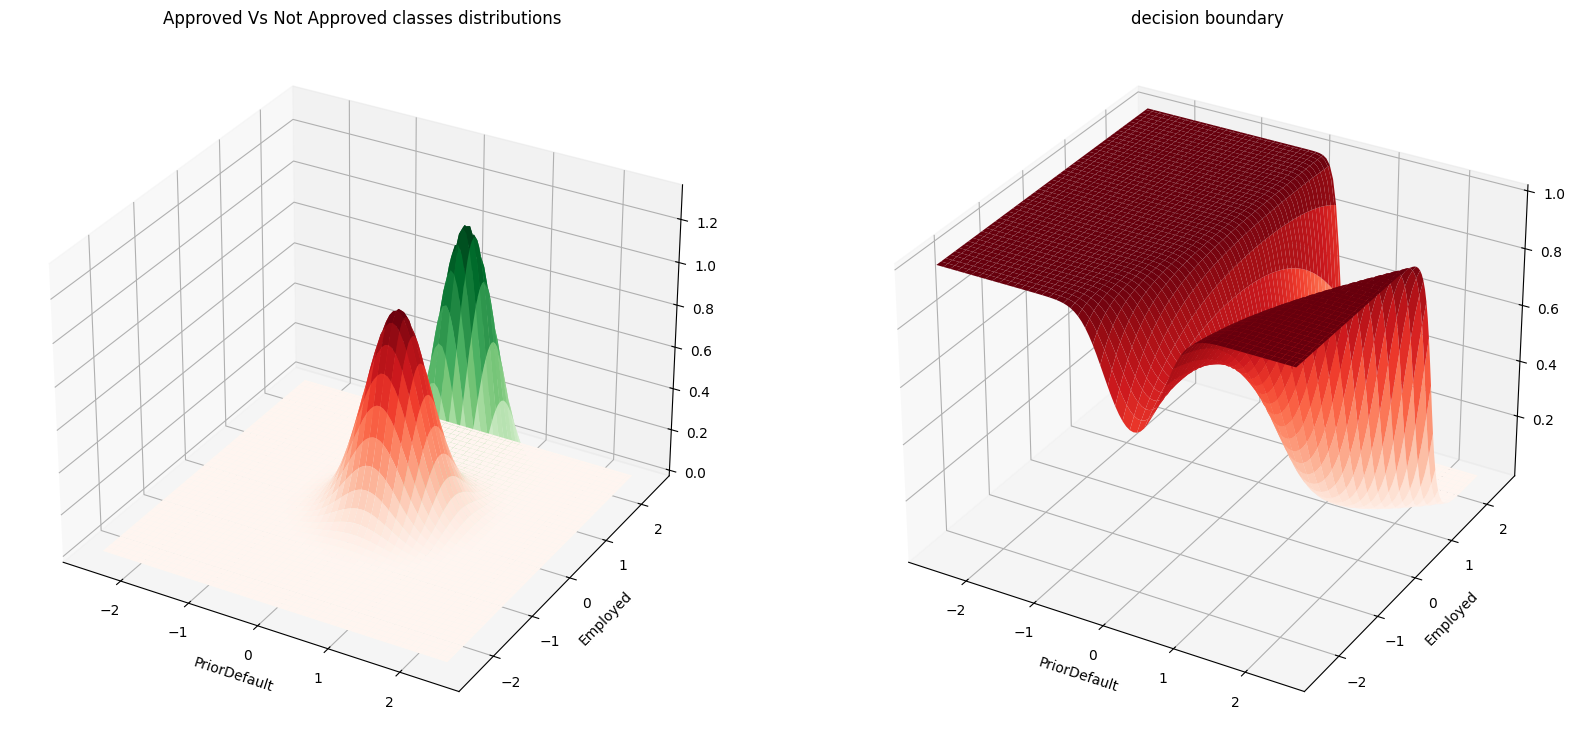

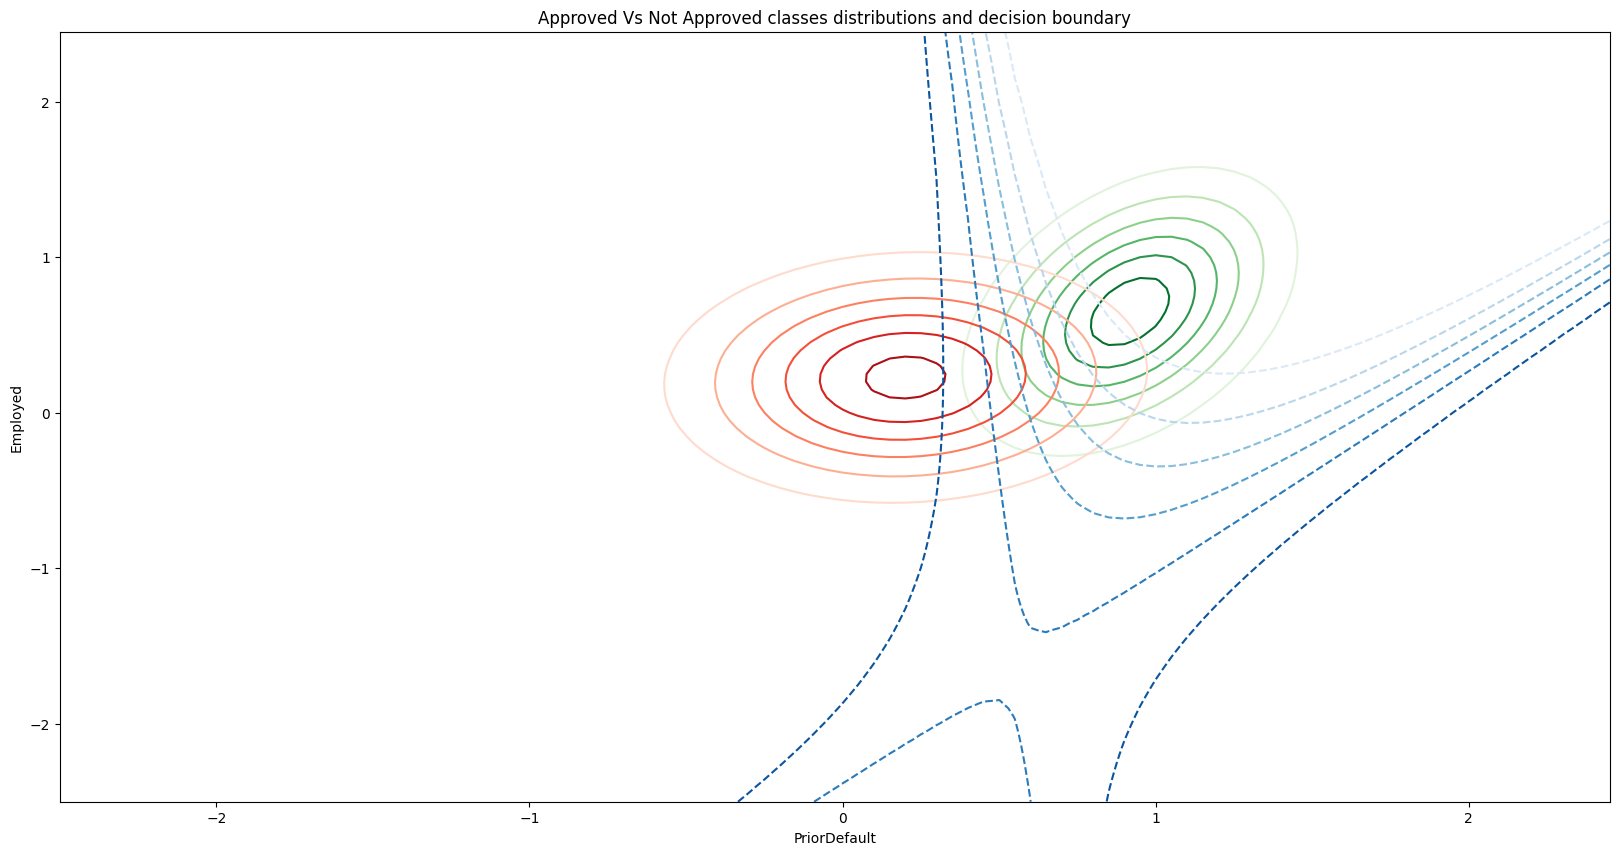

[0.2012987012987013, 0.22727272727272727]
[0.9180327868852459, 0.6516393442622951]


In [79]:
# create an empty array of the same shape as X to hold the (x, y) coordinates
pos = np.empty(X1.shape + (2,))

# fill the pos array with the x and y coordinates
pos[:, :, 0] = X1  
pos[:, :, 1] = X2  

# create a multivariate normal distribution using the defined parameters which is the probability of X given each class 
#P(X|C0)
probabilityOfXGivenClass0 = multivariate_normal(SM0, SCov0).pdf(pos)
#P(X|C1)
probabilityOfXGivenClass1 = multivariate_normal(SM1, SCov1).pdf(pos)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection = '3d')
b=ax.plot_surface(X1, X2, probabilityOfXGivenClass1,cmap='Greens')
a=ax.plot_surface(X1, X2, probabilityOfXGivenClass0,cmap='Reds')
plt.xlabel('PriorDefault')
plt.ylabel('Employed')
plt.title('Approved Vs Not Approved classes distributions')

ax = fig.add_subplot(122, projection = '3d')
a=ax.plot_surface(X1, X2, probabilityOfClass0GivenX,cmap='Reds')
plt.xlabel('PriorDefault')
plt.ylabel('Employed')
plt.title('decision boundary')


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
b=ax.contour(X1, X2, probabilityOfXGivenClass1,cmap='Greens')
a=ax.contour(X1, X2, probabilityOfXGivenClass0,cmap='Reds')
c=ax.contour(X1, X2, probabilityOfClass0GivenX,cmap='Blues',linestyles='dashed') 
plt.xlabel('PriorDefault')
plt.ylabel('Employed')
plt.title('Approved Vs Not Approved classes distributions and decision boundary')

plt.show()

print([M0[feature1Index], M0[feature2Index]])
print([M1[feature1Index], M1[feature2Index]])

In [80]:
# inference stage
#decision boundary calculations P(C0|X)
invCov0 = np.linalg.inv(Cov0)
detCov0 = np.linalg.det(Cov0)

invCov1 = np.linalg.inv(Cov1)
detCov1 = np.linalg.det(Cov1)

W2 = 1/2 * (invCov1-invCov0)
W1 = invCov0.dot(M0)-invCov1.dot(M1)
W0 = - (1/2)*(M0.T.dot(invCov0.dot(M0)))  +  (1/2)*(M1.T.dot(invCov1.dot(M1))) + (1/2)*np.log(detCov1/detCov0) + np.log(Pi/(1-Pi))

# all training data XTrain , and testing Data XTest
XTrain = train.drop(['Approved','Married'],axis=1).to_numpy()
YTrain = train['Approved'].to_numpy()
XTest = test.drop(['Approved','Married'],axis=1).to_numpy()
YTest = test['Approved'].to_numpy()

Training Accuracy  0.8007246376811594
Training F-score  0.8405797101449276


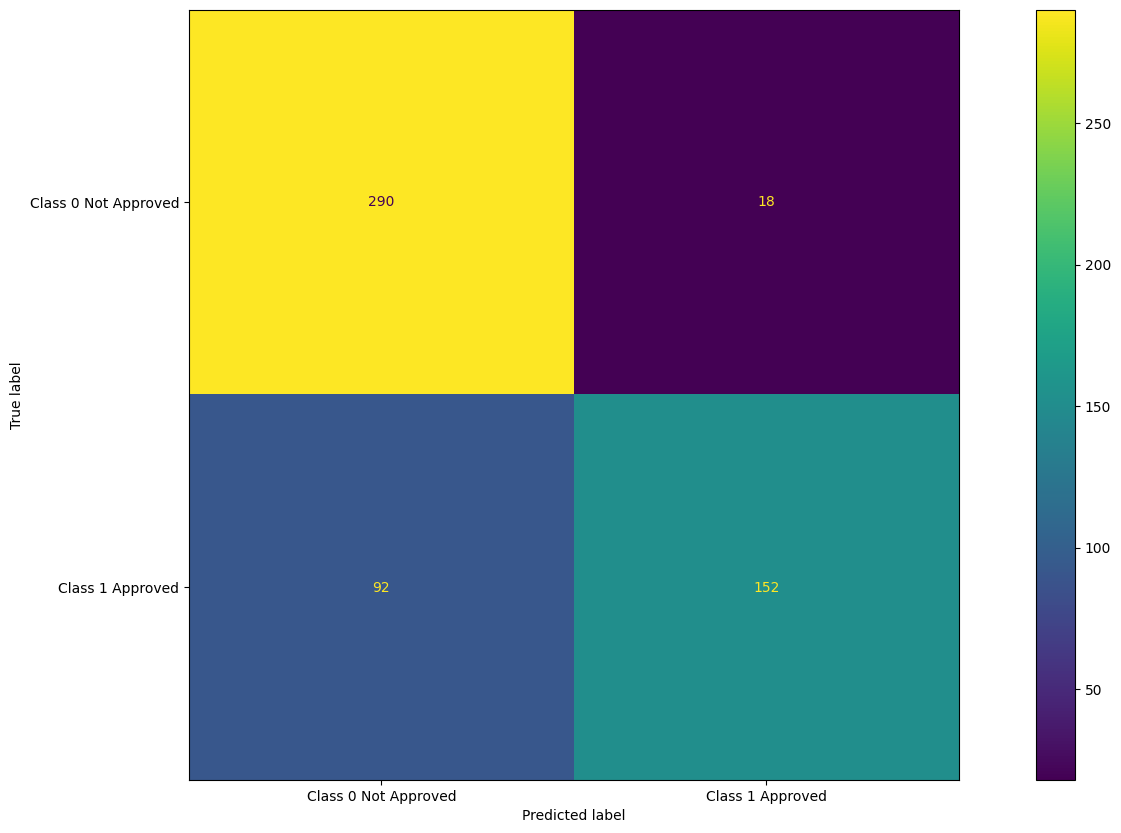

In [81]:
probabilityOfClass0GivenX_Training = np.diagonal(XTrain.dot(W2.dot(XTrain.T)))+XTrain.dot(W1)+W0
probabilityOfClass0GivenX_Training = 1/(1+np.exp(-probabilityOfClass0GivenX_Training))
prediction = probabilityOfClass0GivenX_Training.copy()
prediction[probabilityOfClass0GivenX_Training>=0.5]=0
prediction[probabilityOfClass0GivenX_Training<0.5]=1


TruePositive = np.where(np.logical_and(YTrain == prediction , prediction==0))[0].shape[0]
TrueNegative = np.where(np.logical_and(YTrain == prediction , prediction==1))[0].shape[0]
FalsePositive = np.where(np.logical_and(YTrain != prediction , prediction==0))[0].shape[0]
FalseNegative = np.where(np.logical_and(YTrain != prediction , prediction==1))[0].shape[0]
totalPredictions = prediction.shape[0]
Accuracy = (TruePositive+TrueNegative)/totalPredictions # (True Positive + True Negative) / Total Predictions is 
Precision = (TruePositive)/(TruePositive+FalsePositive) # Precision True Positive / (True Positive + False Positive)
Recall = (TruePositive)/(TruePositive+FalseNegative) # Recall True Positive / (True Positive + False Negative)
F_score = 2*(Precision*Recall)/(Precision + Recall) # 2 * ((Precision * Recall) / (Precision + Recall))
print("Training Accuracy ",Accuracy)
print("Training F-score ",F_score)
fig, ax = plt.subplots(1,1,figsize=(20,10))
confusion_matrix = metrics.confusion_matrix(YTrain, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Class 0 Not Approved", "Class 1 Approved"])
cm_display.plot(ax=ax)

Testing Accuracy  0.8405797101449275
Testing F-score  0.8658536585365854


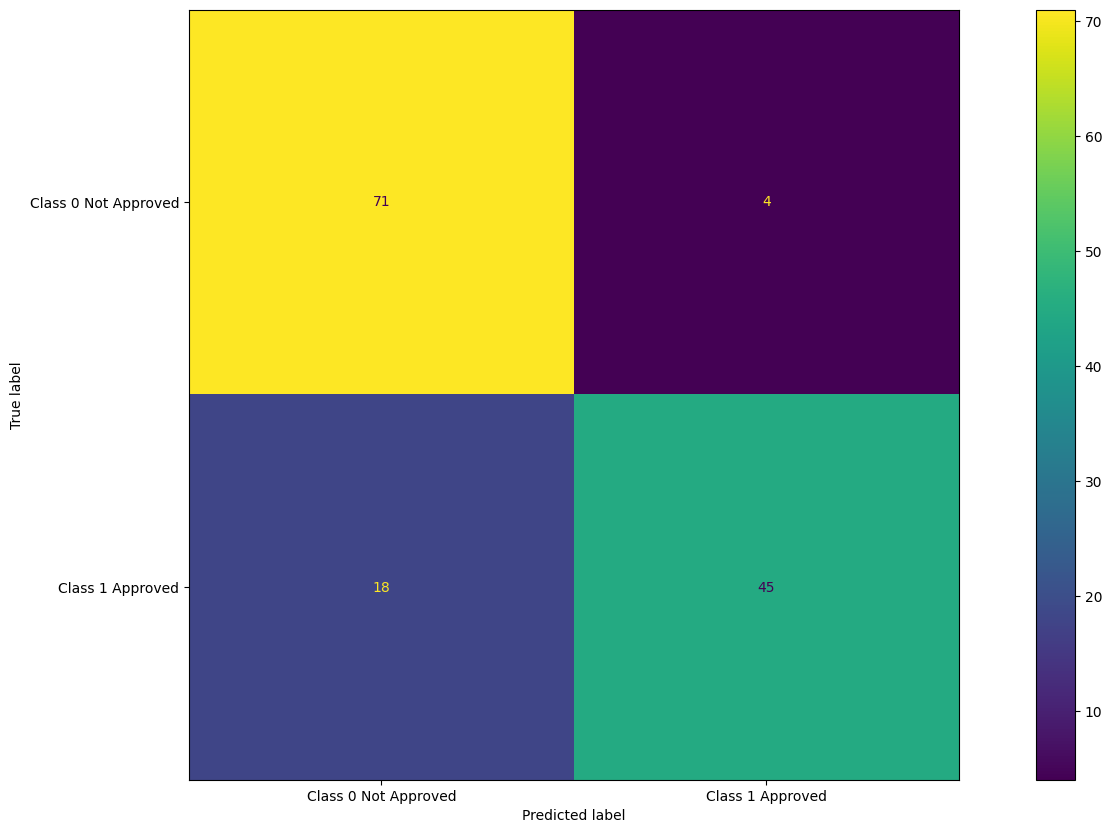

In [82]:
probabilityOfClass0GivenX_Testing = np.diagonal(XTest.dot(W2.dot(XTest.T)))+XTest.dot(W1)+W0
probabilityOfClass0GivenX_Testing = 1/(1+np.exp(-probabilityOfClass0GivenX_Testing))
prediction = probabilityOfClass0GivenX_Testing.copy()
prediction[probabilityOfClass0GivenX_Testing>=0.5]=0
prediction[probabilityOfClass0GivenX_Testing<0.5]=1


TruePositive = np.where(np.logical_and(YTest == prediction , prediction==0))[0].shape[0]
TrueNegative = np.where(np.logical_and(YTest == prediction , prediction==1))[0].shape[0]
FalsePositive = np.where(np.logical_and(YTest != prediction , prediction==0))[0].shape[0]
FalseNegative = np.where(np.logical_and(YTest != prediction , prediction==1))[0].shape[0]
totalPredictions = prediction.shape[0]
Accuracy = (TruePositive+TrueNegative)/totalPredictions # (True Positive + True Negative) / Total Predictions is 
Precision = (TruePositive)/(TruePositive+FalsePositive) # Precision True Positive / (True Positive + False Positive)
Recall = (TruePositive)/(TruePositive+FalseNegative) # Recall True Positive / (True Positive + False Negative)
F_score = 2*(Precision*Recall)/(Precision + Recall) # 2 * ((Precision * Recall) / (Precision + Recall))
print("Testing Accuracy ",Accuracy)
print("Testing F-score ",F_score)
fig, ax = plt.subplots(1,1,figsize=(20,10))
confusion_matrix = metrics.confusion_matrix(YTest, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Class 0 Not Approved", "Class 1 Approved"])
cm_display.plot(ax=ax)

In [83]:
# https://medium.com/@akshay.sinha/generative-probabilistic-modeling-theory-of-naive-bayes-classifier-8bf8744afe1d

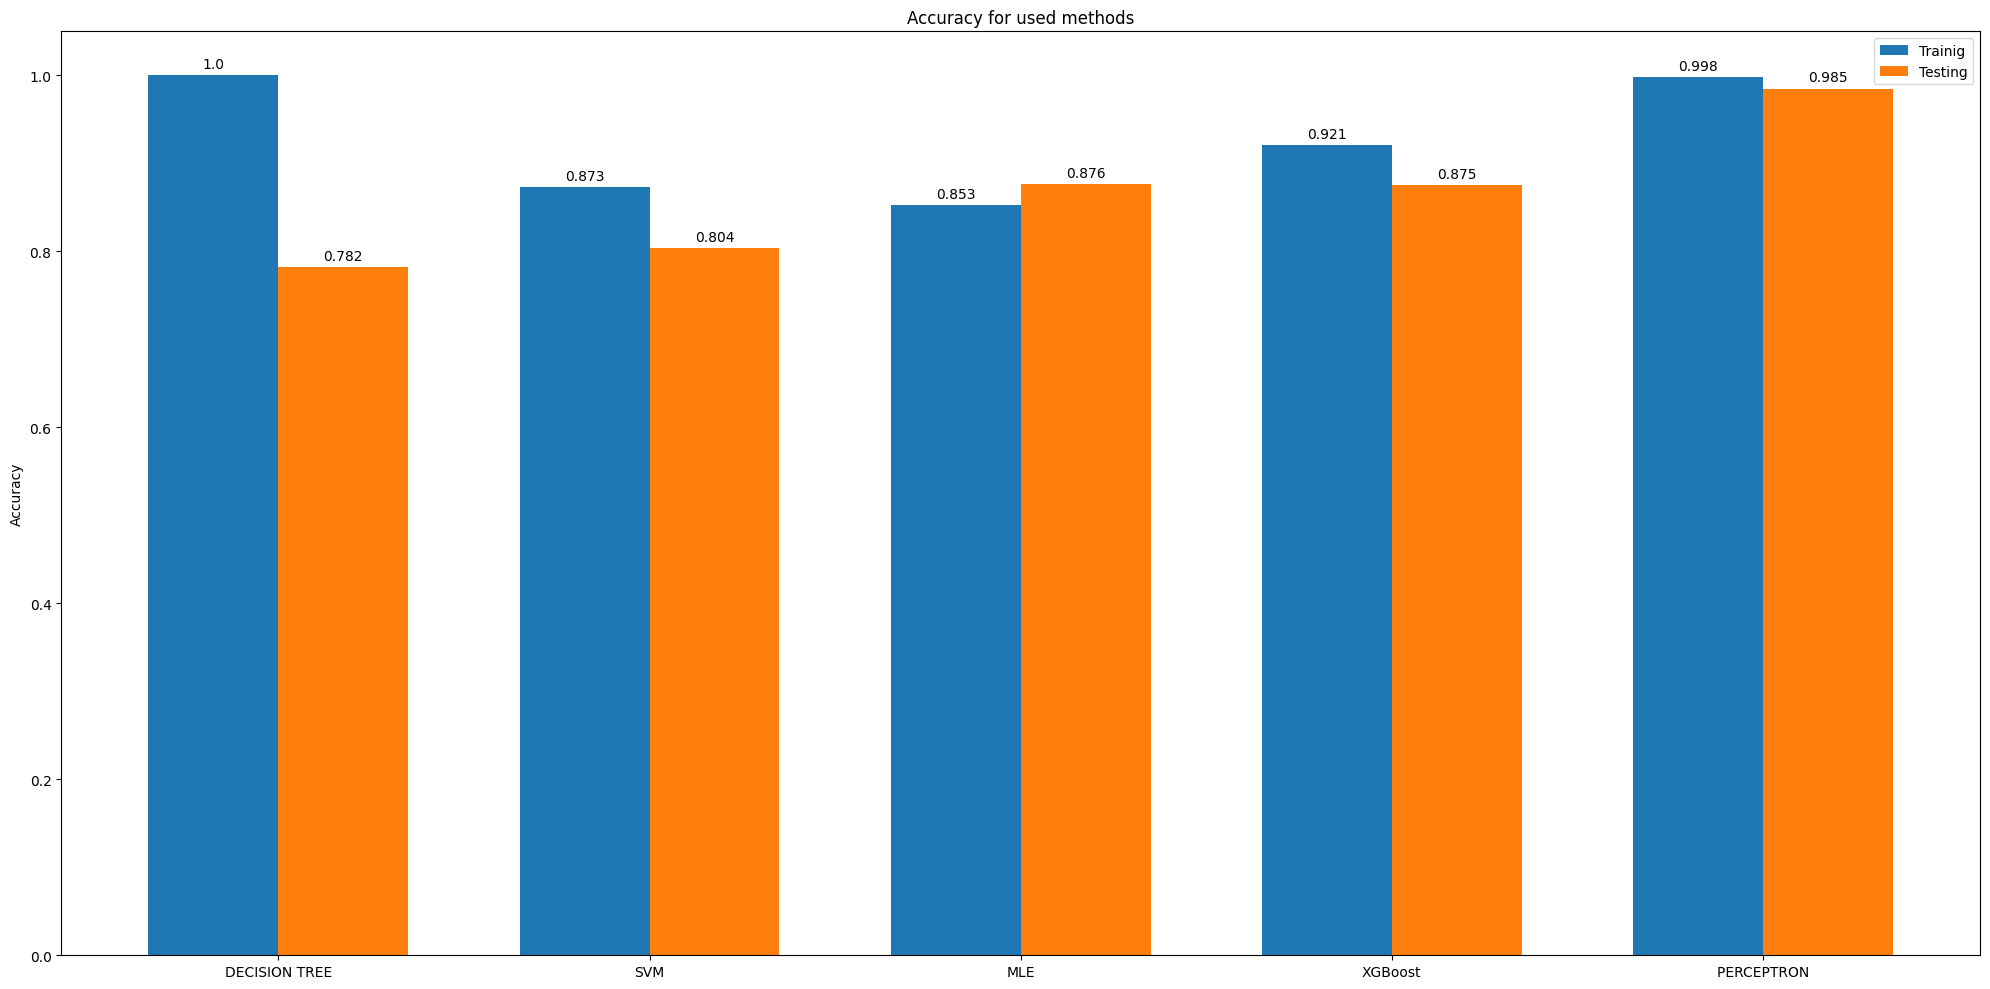

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['DECISION TREE', 'SVM', 'MLE', 'XGBoost', 'PERCEPTRON​']
men_means = [1.0, .873, 0.853, 0.921, 0.998]
women_means = [.782, .804, 0.876, 0.875, 0.985]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, men_means, width, label='Trainig')
rects2 = ax.bar(x + width/2, women_means, width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for used methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
